In [1]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py as h5
import scienceplots

In [2]:
sys.path.append("../../..")

In [3]:
from source.NAHEA_CNN import NAHEA_CNN_1

In [4]:
plt.style.use(["science", "grid"])

In [5]:
# load data from sin dataset
data_save_dir = Path("../../../data") / "sin"
data_save_path_train = data_save_dir / "train.h5"
data_save_path_test = data_save_dir / "test.h5"

with h5.File(data_save_path_train, "r") as f:
    X_train_full = f["X"][:].squeeze(2)
    y_train_full = f["y"][:]

with h5.File(data_save_path_test, "r") as f:
    X_test = f["X"][:].squeeze(2)
    y_test = f["y"][:]

print(f"X_train shape: {X_train_full.shape}")
print(f"y_train shape: {y_train_full.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4000, 18)
y_train shape: (4000, 1)
X_test shape: (1000, 18)
y_test shape: (1000, 1)


In [6]:
n_train = 150
n_val = 250 # validation is much faster than training
n_test = 500 # testing is much faster than training
X_train = X_train_full[:n_train]
y_train = y_train_full[:n_train]
X_val = X_train_full[n_train:n_train+n_val]
y_val = y_train_full[n_train:n_train+n_val]
X_test = X_test[:n_test]
y_test = y_test[:n_test]

seq_len = X_train.shape[1]

Saved figure to figures/generated_sin_wave_data_samples.pdf


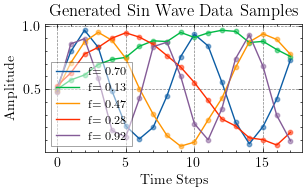

In [7]:
# plot some data
textwidth = 3.31314
aspect_ratio = 4/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio
fig = plt.figure(figsize=(width, height))
# plt.figure(figsize=(10, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(5):
    plt.plot(X_train[i].flatten(), label=f"f= {y_train[i][0]:.2f}", color=colors[i % len(colors)])
    plt.scatter(np.arange(seq_len), X_train[i].flatten(), color=colors[i % len(colors)], s=10, alpha=0.5)
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
legend = plt.legend(fancybox=False, edgecolor="black", fontsize='small', framealpha=0.5)
legend.get_frame().set_linewidth(0.5)
path = Path("figures")
path.mkdir(parents=True, exist_ok=True)
plt.savefig(path / "generated_sin_wave_data_samples.pdf", bbox_inches='tight', dpi=300)
print(f"Saved figure to {path / 'generated_sin_wave_data_samples.pdf'}")
plt.show()

In [8]:
seq_len = X_train.shape[1]
hparams = {
    "n_features": (n_features := 4),  # =1D kernel size = number of qubits
    "sampling_rate": 0.2,
    "protocol": "min-delay",
    "n_ancilliary_qubits": (n_ancilliary_qubits := 0), # not implemented
    "input_length": seq_len,
    "stride": 3,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
}

sep = 7.0
parameters = {
    # separation of 7 between the qubits
    "positions": [[sep * i - (sep * 2), 0] for i in range(n_features)],
    "local_pulses_omega_1": [0.5, 1.0, 1.5, 1.0], #, 0.5],
    "local_pulses_delta_1": [0.0] * n_features,
    "global_pulse_omega_1": 1.0,
    "global_pulse_delta_1": 0.0,
    "global_pulse_omega_2": 0.5,
    "global_pulse_delta_2": 0.0,
    "global_pulse_duration": 100,
    "local_pulse_duration": 80,
    "embed_pulse_duration": 80,
}


NAHEA_CNN = NAHEA_CNN_1(
    hparams=hparams, parameters=parameters, name="NAHEA_CNN_3"
)

# set some parameters to not require gradients. They didn't change much last time
NAHEA_CNN._parameters["positions"].requires_grad = False
NAHEA_CNN._parameters["local_pulses_delta_1"].requires_grad = False
NAHEA_CNN._parameters["global_pulse_delta_1"].requires_grad = False
NAHEA_CNN._parameters["global_pulse_delta_2"].requires_grad = False

Adding parameter 0.weight to model
Adding parameter 0.bias to model
Adding parameter 2.weight to model
Adding parameter 2.bias to model
Adding parameter 4.weight to model
Adding parameter 4.bias to model


In [9]:
from multiprocessing import Pool

def forward_no_grad(xx: Tensor):
    with torch.no_grad():
        return NAHEA_CNN.forward(xx, dist_grad=False)
n_cpus = 10

In [ ]:
# train the model
x_val = torch.tensor(X_val, dtype=torch.float64)
y_val = torch.tensor(y_val, dtype=torch.float64)
if len(y_val.shape) == 2:
    y_val = y_val.squeeze(1)  # make sure y_val is 2D
batch_size = 16
epochs = 50
loss_hist = []
loss_hist_val = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
NAHEA_CNN.train()
optimizer = torch.optim.Adam(
    [param for _, param in NAHEA_CNN.parameters().items() if param.requires_grad],
    lr=0.01,
    weight_decay=1e-5,
)
params_hist = [copy.deepcopy(NAHEA_CNN.parameters())]
for epoch in range(epochs):
    NAHEA_CNN.train()
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}", leave=False):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64)
        y_batch = torch.tensor(
            y_train[i : i + batch_size], dtype=torch.float64
        ).squeeze(1)
        batch_out = [NAHEA_CNN.forward(xx, dist_grad=False) for xx in x_batch]
        predicted = torch.stack([bo["output"] for bo in batch_out])
        loss = loss_fn(predicted.squeeze(1), y_batch)
        tqdm.write(
            f"Batch {i // batch_size + 1} loss: {loss.item():.4f}, "
            f"RMSE: {np.sqrt(loss.item()):.4f}"
        )
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append(copy.deepcopy(NAHEA_CNN.parameters()))
    epoch_loss = np.mean(epoch_losses)

    # validation
    with torch.no_grad():
        NAHEA_CNN.eval()
        with Pool(n_cpus) as pool:
            batch_out = list(tqdm(pool.imap(forward_no_grad, torch.tensor(X_val, dtype=torch.float64)), desc="Validation", total=len(X_val), leave=False))
        predicted = torch.stack([bo["output"] for bo in batch_out])
        val_loss = loss_fn(predicted.squeeze(1), y_val)
        loss_hist_val.append(val_loss.item())
    tqdm.write(f"Epoch {epoch+1}: train RMSE: {np.sqrt(epoch_loss):.4f}, "
               f"validation RMSE: {np.sqrt(val_loss.item()):.4f}")
loss_hist = np.array(loss_hist)
print(f"Final loss (RMSE): {np.sqrt(loss_hist[-1])}")
print(f"Final validation loss (RMSE): {np.sqrt(loss_hist_val[-1])}")

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.6016, RMSE: 0.7756
Batch 2 loss: 0.6145, RMSE: 0.7839
Batch 3 loss: 0.3778, RMSE: 0.6147
Batch 4 loss: 0.3893, RMSE: 0.6240
Batch 5 loss: 0.2191, RMSE: 0.4681
Batch 6 loss: 0.4283, RMSE: 0.6544
Batch 7 loss: 0.2141, RMSE: 0.4627
Batch 8 loss: 0.2411, RMSE: 0.4911
Batch 9 loss: 0.2323, RMSE: 0.4819
Batch 10 loss: 0.2335, RMSE: 0.4832


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1: train RMSE: 0.5960, validation RMSE: 0.5276


Epoch 2:   0%|          | 0/10 [00:06<?, ?it/s]

Batch 1 loss: 0.2913, RMSE: 0.5397
Batch 2 loss: 0.2570, RMSE: 0.5069
Batch 3 loss: 0.2962, RMSE: 0.5443
Batch 4 loss: 0.2022, RMSE: 0.4497
Batch 5 loss: 0.2011, RMSE: 0.4484
Batch 6 loss: 0.2103, RMSE: 0.4585
Batch 7 loss: 0.1895, RMSE: 0.4353
Batch 8 loss: 0.1485, RMSE: 0.3853
Batch 9 loss: 0.1051, RMSE: 0.3242
Batch 10 loss: 0.0723, RMSE: 0.2689


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2: train RMSE: 0.4442, validation RMSE: 0.4041


Epoch 3:   0%|          | 0/10 [00:03<?, ?it/s]

Batch 1 loss: 0.1444, RMSE: 0.3799
Batch 2 loss: 0.1189, RMSE: 0.3448
Batch 3 loss: 0.1368, RMSE: 0.3698
Batch 4 loss: 0.0700, RMSE: 0.2646
Batch 5 loss: 0.0710, RMSE: 0.2665
Batch 6 loss: 0.0920, RMSE: 0.3033
Batch 7 loss: 0.1389, RMSE: 0.3727
Batch 8 loss: 0.0479, RMSE: 0.2189
Batch 9 loss: 0.0765, RMSE: 0.2765
Batch 10 loss: 0.0683, RMSE: 0.2614


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3: train RMSE: 0.3106, validation RMSE: 0.2699


Epoch 4:   0%|          | 0/10 [00:04<?, ?it/s]

Batch 1 loss: 0.0680, RMSE: 0.2607
Batch 2 loss: 0.0544, RMSE: 0.2332
Batch 3 loss: 0.0489, RMSE: 0.2211
Batch 4 loss: 0.0702, RMSE: 0.2650
Batch 5 loss: 0.0732, RMSE: 0.2705
Batch 6 loss: 0.0719, RMSE: 0.2681
Batch 7 loss: 0.0723, RMSE: 0.2689
Batch 8 loss: 0.0529, RMSE: 0.2301
Batch 9 loss: 0.0946, RMSE: 0.3076
Batch 10 loss: 0.0929, RMSE: 0.3047


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4: train RMSE: 0.2644, validation RMSE: 0.2704


Epoch 5:   0%|          | 0/10 [00:05<?, ?it/s]

Batch 1 loss: 0.0689, RMSE: 0.2626
Batch 2 loss: 0.0641, RMSE: 0.2533
Batch 3 loss: 0.0930, RMSE: 0.3049
Batch 4 loss: 0.0699, RMSE: 0.2643
Batch 5 loss: 0.0632, RMSE: 0.2514
Batch 6 loss: 0.0619, RMSE: 0.2488
Batch 7 loss: 0.0504, RMSE: 0.2244
Batch 8 loss: 0.0716, RMSE: 0.2675
Batch 9 loss: 0.0528, RMSE: 0.2297
Batch 10 loss: 0.0605, RMSE: 0.2460


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5: train RMSE: 0.2562, validation RMSE: 0.2661


Epoch 6:   0%|          | 0/10 [00:04<?, ?it/s]

Batch 1 loss: 0.0770, RMSE: 0.2775
Batch 2 loss: 0.0735, RMSE: 0.2711
Batch 3 loss: 0.0805, RMSE: 0.2838
Batch 4 loss: 0.0830, RMSE: 0.2881
Batch 5 loss: 0.0461, RMSE: 0.2148
Batch 6 loss: 0.0510, RMSE: 0.2259
Batch 7 loss: 0.0430, RMSE: 0.2073
Batch 8 loss: 0.0609, RMSE: 0.2469
Batch 9 loss: 0.0535, RMSE: 0.2312
Batch 10 loss: 0.0776, RMSE: 0.2785


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6: train RMSE: 0.2542, validation RMSE: 0.2648


Epoch 7:   0%|          | 0/10 [00:02<?, ?it/s]

Batch 1 loss: 0.0559, RMSE: 0.2364
Batch 2 loss: 0.0529, RMSE: 0.2299
Batch 3 loss: 0.0813, RMSE: 0.2851
Batch 4 loss: 0.0598, RMSE: 0.2445
Batch 5 loss: 0.0684, RMSE: 0.2615
Batch 6 loss: 0.0440, RMSE: 0.2097
Batch 7 loss: 0.0579, RMSE: 0.2407
Batch 8 loss: 0.0647, RMSE: 0.2543
Batch 9 loss: 0.0679, RMSE: 0.2605
Batch 10 loss: 0.1021, RMSE: 0.3195


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7: train RMSE: 0.2559, validation RMSE: 0.2639


Epoch 8:   0%|          | 0/10 [00:06<?, ?it/s]

Batch 1 loss: 0.0668, RMSE: 0.2584
Batch 2 loss: 0.0555, RMSE: 0.2356
Batch 3 loss: 0.0529, RMSE: 0.2300
Batch 4 loss: 0.0670, RMSE: 0.2589
Batch 5 loss: 0.0808, RMSE: 0.2842
Batch 6 loss: 0.0572, RMSE: 0.2392
Batch 7 loss: 0.0631, RMSE: 0.2513
Batch 8 loss: 0.0477, RMSE: 0.2184
Batch 9 loss: 0.0680, RMSE: 0.2609
Batch 10 loss: 0.0401, RMSE: 0.2002


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8: train RMSE: 0.2448, validation RMSE: 0.2553


Epoch 9:   0%|          | 0/10 [00:04<?, ?it/s]

Batch 1 loss: 0.0644, RMSE: 0.2539
Batch 2 loss: 0.0458, RMSE: 0.2141
Batch 3 loss: 0.0496, RMSE: 0.2227
Batch 4 loss: 0.0391, RMSE: 0.1976
Batch 5 loss: 0.0779, RMSE: 0.2792
Batch 6 loss: 0.0618, RMSE: 0.2485
Batch 7 loss: 0.0975, RMSE: 0.3123
Batch 8 loss: 0.0655, RMSE: 0.2559
Batch 9 loss: 0.0448, RMSE: 0.2116
Batch 10 loss: 0.0697, RMSE: 0.2641


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9: train RMSE: 0.2482, validation RMSE: 0.2524


Epoch 10:   0%|          | 0/10 [00:05<?, ?it/s]

Batch 1 loss: 0.0512, RMSE: 0.2264
Batch 2 loss: 0.0519, RMSE: 0.2279
Batch 3 loss: 0.0578, RMSE: 0.2404
Batch 4 loss: 0.0401, RMSE: 0.2003
Batch 5 loss: 0.0352, RMSE: 0.1876
Batch 6 loss: 0.0599, RMSE: 0.2448
Batch 7 loss: 0.0872, RMSE: 0.2952
Batch 8 loss: 0.0641, RMSE: 0.2531
Batch 9 loss: 0.0701, RMSE: 0.2647
Batch 10 loss: 0.0490, RMSE: 0.2214


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10: train RMSE: 0.2380, validation RMSE: 0.2453


Epoch 11:   0%|          | 0/10 [00:03<?, ?it/s]

Batch 1 loss: 0.0652, RMSE: 0.2553
Batch 2 loss: 0.0584, RMSE: 0.2416
Batch 3 loss: 0.0584, RMSE: 0.2417
Batch 4 loss: 0.0651, RMSE: 0.2551
Batch 5 loss: 0.0424, RMSE: 0.2060
Batch 6 loss: 0.0468, RMSE: 0.2162
Batch 7 loss: 0.0394, RMSE: 0.1985
Batch 8 loss: 0.0443, RMSE: 0.2105
Batch 9 loss: 0.0523, RMSE: 0.2286
Batch 10 loss: 0.0446, RMSE: 0.2112


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 11: train RMSE: 0.2273, validation RMSE: 0.2258


Epoch 12:   0%|          | 0/10 [00:03<?, ?it/s]

Batch 1 loss: 0.0710, RMSE: 0.2665
Batch 2 loss: 0.0533, RMSE: 0.2309
Batch 3 loss: 0.0493, RMSE: 0.2220
Batch 4 loss: 0.0306, RMSE: 0.1749
Batch 5 loss: 0.0168, RMSE: 0.1295
Batch 6 loss: 0.0413, RMSE: 0.2033
Batch 7 loss: 0.0466, RMSE: 0.2160
Batch 8 loss: 0.0448, RMSE: 0.2117
Batch 9 loss: 0.0373, RMSE: 0.1931
Batch 10 loss: 0.0319, RMSE: 0.1787


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 12: train RMSE: 0.2057, validation RMSE: 0.1930


Epoch 13:   0%|          | 0/10 [00:02<?, ?it/s]

Batch 1 loss: 0.0305, RMSE: 0.1747
Batch 2 loss: 0.0418, RMSE: 0.2045
Batch 3 loss: 0.0291, RMSE: 0.1706
Batch 4 loss: 0.0207, RMSE: 0.1438
Batch 5 loss: 0.0249, RMSE: 0.1579
Batch 6 loss: 0.0263, RMSE: 0.1622
Batch 7 loss: 0.0214, RMSE: 0.1461
Batch 8 loss: 0.0268, RMSE: 0.1638
Batch 9 loss: 0.0172, RMSE: 0.1310
Batch 10 loss: 0.0128, RMSE: 0.1131


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 13: train RMSE: 0.1586, validation RMSE: 0.1400


Epoch 14:   0%|          | 0/10 [00:02<?, ?it/s]

Batch 1 loss: 0.0158, RMSE: 0.1257
Batch 2 loss: 0.0154, RMSE: 0.1239
Batch 3 loss: 0.0095, RMSE: 0.0977
Batch 4 loss: 0.0120, RMSE: 0.1096
Batch 5 loss: 0.0041, RMSE: 0.0637
Batch 6 loss: 0.0188, RMSE: 0.1370
Batch 7 loss: 0.0139, RMSE: 0.1177
Batch 8 loss: 0.0114, RMSE: 0.1069
Batch 9 loss: 0.0107, RMSE: 0.1033
Batch 10 loss: 0.0062, RMSE: 0.0788


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 14: train RMSE: 0.1085, validation RMSE: 0.0934


Epoch 15:   0%|          | 0/10 [00:05<?, ?it/s]

Batch 1 loss: 0.0063, RMSE: 0.0796
Batch 2 loss: 0.0136, RMSE: 0.1168
Batch 3 loss: 0.0089, RMSE: 0.0945
Batch 4 loss: 0.0037, RMSE: 0.0612
Batch 5 loss: 0.0062, RMSE: 0.0787
Batch 6 loss: 0.0050, RMSE: 0.0705
Batch 7 loss: 0.0099, RMSE: 0.0995
Batch 8 loss: 0.0054, RMSE: 0.0736
Batch 9 loss: 0.0028, RMSE: 0.0529
Batch 10 loss: 0.0057, RMSE: 0.0758


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 15: train RMSE: 0.0823, validation RMSE: 0.1018


Epoch 16:   0%|          | 0/10 [00:02<?, ?it/s]

Batch 1 loss: 0.0086, RMSE: 0.0930
Batch 2 loss: 0.0070, RMSE: 0.0835
Batch 3 loss: 0.0031, RMSE: 0.0556
Batch 4 loss: 0.0044, RMSE: 0.0661
Batch 5 loss: 0.0057, RMSE: 0.0753
Batch 6 loss: 0.0070, RMSE: 0.0839
Batch 7 loss: 0.0046, RMSE: 0.0676
Batch 8 loss: 0.0030, RMSE: 0.0547
Batch 9 loss: 0.0034, RMSE: 0.0583
Batch 10 loss: 0.0029, RMSE: 0.0534


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 16: train RMSE: 0.0704, validation RMSE: 0.0581


Epoch 17:   0%|          | 0/10 [00:06<?, ?it/s]

Batch 1 loss: 0.0029, RMSE: 0.0539
Batch 2 loss: 0.0037, RMSE: 0.0605
Batch 3 loss: 0.0047, RMSE: 0.0688
Batch 4 loss: 0.0037, RMSE: 0.0606
Batch 5 loss: 0.0013, RMSE: 0.0364
Batch 6 loss: 0.0031, RMSE: 0.0556
Batch 7 loss: 0.0037, RMSE: 0.0610
Batch 8 loss: 0.0033, RMSE: 0.0575
Batch 9 loss: 0.0013, RMSE: 0.0358
Batch 10 loss: 0.0071, RMSE: 0.0845


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 17: train RMSE: 0.0590, validation RMSE: 0.0447


Epoch 18:   0%|          | 0/10 [00:06<?, ?it/s]

Batch 1 loss: 0.0017, RMSE: 0.0409
Batch 2 loss: 0.0019, RMSE: 0.0436
Batch 3 loss: 0.0022, RMSE: 0.0470
Batch 4 loss: 0.0009, RMSE: 0.0303
Batch 5 loss: 0.0023, RMSE: 0.0476
Batch 6 loss: 0.0017, RMSE: 0.0416
Batch 7 loss: 0.0021, RMSE: 0.0457
Batch 8 loss: 0.0022, RMSE: 0.0466
Batch 9 loss: 0.0015, RMSE: 0.0392
Batch 10 loss: 0.0015, RMSE: 0.0391


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 18: train RMSE: 0.0424, validation RMSE: 0.0438


Epoch 19:   0%|          | 0/10 [00:01<?, ?it/s]

Batch 1 loss: 0.0019, RMSE: 0.0439
Batch 2 loss: 0.0021, RMSE: 0.0458
Batch 3 loss: 0.0014, RMSE: 0.0371
Batch 4 loss: 0.0015, RMSE: 0.0392
Batch 5 loss: 0.0023, RMSE: 0.0479
Batch 6 loss: 0.0018, RMSE: 0.0422
Batch 7 loss: 0.0009, RMSE: 0.0308
Batch 8 loss: 0.0029, RMSE: 0.0543
Batch 9 loss: 0.0014, RMSE: 0.0375
Batch 10 loss: 0.0022, RMSE: 0.0470


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 19: train RMSE: 0.0430, validation RMSE: 0.0415


Epoch 20:   0%|          | 0/10 [00:02<?, ?it/s]

Batch 1 loss: 0.0022, RMSE: 0.0464
Batch 2 loss: 0.0013, RMSE: 0.0366
Batch 3 loss: 0.0014, RMSE: 0.0373
Batch 4 loss: 0.0012, RMSE: 0.0340
Batch 5 loss: 0.0014, RMSE: 0.0378
Batch 6 loss: 0.0019, RMSE: 0.0438
Batch 7 loss: 0.0023, RMSE: 0.0478
Batch 8 loss: 0.0011, RMSE: 0.0338
Batch 9 loss: 0.0013, RMSE: 0.0356
Batch 10 loss: 0.0013, RMSE: 0.0365


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 20: train RMSE: 0.0393, validation RMSE: 0.0404


Epoch 21:   0%|          | 0/10 [00:04<?, ?it/s]

Batch 1 loss: 0.0012, RMSE: 0.0347
Batch 2 loss: 0.0014, RMSE: 0.0377
Batch 3 loss: 0.0020, RMSE: 0.0447
Batch 4 loss: 0.0015, RMSE: 0.0384
Batch 5 loss: 0.0016, RMSE: 0.0399
Batch 6 loss: 0.0010, RMSE: 0.0322
Batch 7 loss: 0.0033, RMSE: 0.0570
Batch 8 loss: 0.0012, RMSE: 0.0352
Batch 9 loss: 0.0017, RMSE: 0.0407
Batch 10 loss: 0.0005, RMSE: 0.0221


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 21: train RMSE: 0.0392, validation RMSE: 0.0546


Epoch 22:   0%|          | 0/10 [00:02<?, ?it/s]

Batch 1 loss: 0.0014, RMSE: 0.0378
Batch 2 loss: 0.0040, RMSE: 0.0633
Batch 3 loss: 0.0023, RMSE: 0.0476
Batch 4 loss: 0.0011, RMSE: 0.0334
Batch 5 loss: 0.0015, RMSE: 0.0391
Batch 6 loss: 0.0011, RMSE: 0.0338
Batch 7 loss: 0.0008, RMSE: 0.0281
Batch 8 loss: 0.0013, RMSE: 0.0354
Batch 9 loss: 0.0007, RMSE: 0.0267
Batch 10 loss: 0.0038, RMSE: 0.0616


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 22: train RMSE: 0.0425, validation RMSE: 0.0414


Epoch 23:   0%|          | 0/10 [00:02<?, ?it/s]

Batch 1 loss: 0.0025, RMSE: 0.0504
Batch 2 loss: 0.0013, RMSE: 0.0362
Batch 3 loss: 0.0013, RMSE: 0.0361
Batch 4 loss: 0.0014, RMSE: 0.0369
Batch 5 loss: 0.0013, RMSE: 0.0357
Batch 6 loss: 0.0017, RMSE: 0.0406
Batch 7 loss: 0.0013, RMSE: 0.0366
Batch 8 loss: 0.0010, RMSE: 0.0311
Batch 9 loss: 0.0008, RMSE: 0.0280
Batch 10 loss: 0.0010, RMSE: 0.0312


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 23: train RMSE: 0.0367, validation RMSE: 0.0377


Epoch 24:   0%|          | 0/10 [00:02<?, ?it/s]

Batch 1 loss: 0.0011, RMSE: 0.0327
Batch 2 loss: 0.0017, RMSE: 0.0414
Batch 3 loss: 0.0012, RMSE: 0.0351
Batch 4 loss: 0.0004, RMSE: 0.0209
Batch 5 loss: 0.0014, RMSE: 0.0378
Batch 6 loss: 0.0016, RMSE: 0.0399
Batch 7 loss: 0.0021, RMSE: 0.0458
Batch 8 loss: 0.0005, RMSE: 0.0227
Batch 9 loss: 0.0015, RMSE: 0.0381
Batch 10 loss: 0.0004, RMSE: 0.0195


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 24: train RMSE: 0.0345, validation RMSE: 0.0397


Epoch 25:   0%|          | 0/10 [00:04<?, ?it/s]

Batch 1 loss: 0.0024, RMSE: 0.0489
Batch 2 loss: 0.0015, RMSE: 0.0389
Batch 3 loss: 0.0010, RMSE: 0.0319
Batch 4 loss: 0.0010, RMSE: 0.0311
Batch 5 loss: 0.0017, RMSE: 0.0413
Batch 6 loss: 0.0005, RMSE: 0.0229
Batch 7 loss: 0.0010, RMSE: 0.0309
Batch 8 loss: 0.0005, RMSE: 0.0232
Batch 9 loss: 0.0012, RMSE: 0.0342
Batch 10 loss: 0.0017, RMSE: 0.0409


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 25: train RMSE: 0.0353, validation RMSE: 0.0354


Epoch 26:   0%|          | 0/10 [00:02<?, ?it/s]

Batch 1 loss: 0.0011, RMSE: 0.0334
Batch 2 loss: 0.0008, RMSE: 0.0277
Batch 3 loss: 0.0011, RMSE: 0.0326
Batch 4 loss: 0.0014, RMSE: 0.0373
Batch 5 loss: 0.0015, RMSE: 0.0392
Batch 6 loss: 0.0011, RMSE: 0.0337
Batch 7 loss: 0.0009, RMSE: 0.0305
Batch 8 loss: 0.0004, RMSE: 0.0208
Batch 9 loss: 0.0005, RMSE: 0.0229
Batch 10 loss: 0.0008, RMSE: 0.0290


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 26: train RMSE: 0.0312, validation RMSE: 0.0317


Epoch 27:   0%|          | 0/10 [00:01<?, ?it/s]

Batch 1 loss: 0.0006, RMSE: 0.0250
Batch 2 loss: 0.0007, RMSE: 0.0269
Batch 3 loss: 0.0010, RMSE: 0.0315
Batch 4 loss: 0.0008, RMSE: 0.0291
Batch 5 loss: 0.0010, RMSE: 0.0318
Batch 6 loss: 0.0011, RMSE: 0.0330
Batch 7 loss: 0.0009, RMSE: 0.0299
Batch 8 loss: 0.0009, RMSE: 0.0293
Batch 9 loss: 0.0003, RMSE: 0.0163
Batch 10 loss: 0.0019, RMSE: 0.0438


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 27: train RMSE: 0.0304, validation RMSE: 0.0382


Epoch 28:   0%|          | 0/10 [00:02<?, ?it/s]

Batch 1 loss: 0.0011, RMSE: 0.0324
Batch 2 loss: 0.0006, RMSE: 0.0236
Batch 3 loss: 0.0009, RMSE: 0.0305
Batch 4 loss: 0.0009, RMSE: 0.0298
Batch 5 loss: 0.0012, RMSE: 0.0344
Batch 6 loss: 0.0009, RMSE: 0.0308
Batch 7 loss: 0.0015, RMSE: 0.0385
Batch 8 loss: 0.0009, RMSE: 0.0293
Batch 9 loss: 0.0006, RMSE: 0.0249
Batch 10 loss: 0.0010, RMSE: 0.0315


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 28: train RMSE: 0.0309, validation RMSE: 0.0388


Epoch 29:   0%|          | 0/10 [00:04<?, ?it/s]

Batch 1 loss: 0.0010, RMSE: 0.0316
Batch 2 loss: 0.0011, RMSE: 0.0335
Batch 3 loss: 0.0005, RMSE: 0.0229
Batch 4 loss: 0.0011, RMSE: 0.0335
Batch 5 loss: 0.0012, RMSE: 0.0351
Batch 6 loss: 0.0008, RMSE: 0.0284
Batch 7 loss: 0.0006, RMSE: 0.0240
Batch 8 loss: 0.0007, RMSE: 0.0257
Batch 9 loss: 0.0011, RMSE: 0.0333
Batch 10 loss: 0.0003, RMSE: 0.0180


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 29: train RMSE: 0.0291, validation RMSE: 0.0293


Epoch 30:   0%|          | 0/10 [00:03<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0232
Batch 2 loss: 0.0008, RMSE: 0.0279
Batch 3 loss: 0.0005, RMSE: 0.0226
Batch 4 loss: 0.0012, RMSE: 0.0340
Batch 5 loss: 0.0006, RMSE: 0.0245
Batch 6 loss: 0.0006, RMSE: 0.0248
Batch 7 loss: 0.0008, RMSE: 0.0280
Batch 8 loss: 0.0011, RMSE: 0.0327
Batch 9 loss: 0.0005, RMSE: 0.0216
Batch 10 loss: 0.0003, RMSE: 0.0174


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 30: train RMSE: 0.0261, validation RMSE: 0.0353


Epoch 31:   0%|          | 0/10 [00:03<?, ?it/s]

Batch 1 loss: 0.0008, RMSE: 0.0284
Batch 2 loss: 0.0006, RMSE: 0.0242
Batch 3 loss: 0.0007, RMSE: 0.0261
Batch 4 loss: 0.0008, RMSE: 0.0285
Batch 5 loss: 0.0007, RMSE: 0.0258
Batch 6 loss: 0.0007, RMSE: 0.0260
Batch 7 loss: 0.0003, RMSE: 0.0180
Batch 8 loss: 0.0009, RMSE: 0.0304
Batch 9 loss: 0.0005, RMSE: 0.0215
Batch 10 loss: 0.0014, RMSE: 0.0378


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 31: train RMSE: 0.0271, validation RMSE: 0.0287


Epoch 32:   0%|          | 0/10 [00:02<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0218
Batch 2 loss: 0.0008, RMSE: 0.0280
Batch 3 loss: 0.0010, RMSE: 0.0322
Batch 4 loss: 0.0005, RMSE: 0.0222
Batch 5 loss: 0.0005, RMSE: 0.0231
Batch 6 loss: 0.0006, RMSE: 0.0244
Batch 7 loss: 0.0005, RMSE: 0.0231
Batch 8 loss: 0.0008, RMSE: 0.0277
Batch 9 loss: 0.0006, RMSE: 0.0236
Batch 10 loss: 0.0002, RMSE: 0.0155


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 32: train RMSE: 0.0245, validation RMSE: 0.0270


Epoch 33:   0%|          | 0/10 [00:04<?, ?it/s]

Batch 1 loss: 0.0002, RMSE: 0.0146
Batch 2 loss: 0.0006, RMSE: 0.0239
Batch 3 loss: 0.0006, RMSE: 0.0235
Batch 4 loss: 0.0008, RMSE: 0.0286
Batch 5 loss: 0.0008, RMSE: 0.0275
Batch 6 loss: 0.0005, RMSE: 0.0227
Batch 7 loss: 0.0006, RMSE: 0.0239
Batch 8 loss: 0.0008, RMSE: 0.0279
Batch 9 loss: 0.0004, RMSE: 0.0201
Batch 10 loss: 0.0006, RMSE: 0.0244


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 33: train RMSE: 0.0240, validation RMSE: 0.0274


Epoch 34:   0%|          | 0/10 [00:02<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0217
Batch 2 loss: 0.0008, RMSE: 0.0284
Batch 3 loss: 0.0006, RMSE: 0.0252
Batch 4 loss: 0.0008, RMSE: 0.0283
Batch 5 loss: 0.0007, RMSE: 0.0261
Batch 6 loss: 0.0006, RMSE: 0.0244
Batch 7 loss: 0.0006, RMSE: 0.0241
Batch 8 loss: 0.0009, RMSE: 0.0305
Batch 9 loss: 0.0003, RMSE: 0.0184
Batch 10 loss: 0.0006, RMSE: 0.0246


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 34: train RMSE: 0.0254, validation RMSE: 0.0263


Epoch 35:   0%|          | 0/10 [00:04<?, ?it/s]

Batch 1 loss: 0.0003, RMSE: 0.0177
Batch 2 loss: 0.0004, RMSE: 0.0212
Batch 3 loss: 0.0007, RMSE: 0.0260
Batch 4 loss: 0.0004, RMSE: 0.0202
Batch 5 loss: 0.0003, RMSE: 0.0182
Batch 6 loss: 0.0008, RMSE: 0.0280
Batch 7 loss: 0.0006, RMSE: 0.0238
Batch 8 loss: 0.0006, RMSE: 0.0235
Batch 9 loss: 0.0009, RMSE: 0.0297
Batch 10 loss: 0.0004, RMSE: 0.0206


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 35: train RMSE: 0.0232, validation RMSE: 0.0257


Epoch 36:   0%|          | 0/10 [00:03<?, ?it/s]

Batch 1 loss: 0.0009, RMSE: 0.0295
Batch 2 loss: 0.0004, RMSE: 0.0197
Batch 3 loss: 0.0004, RMSE: 0.0196
Batch 4 loss: 0.0003, RMSE: 0.0176
Batch 5 loss: 0.0005, RMSE: 0.0220
Batch 6 loss: 0.0006, RMSE: 0.0238
Batch 7 loss: 0.0004, RMSE: 0.0208
Batch 8 loss: 0.0009, RMSE: 0.0301
Batch 9 loss: 0.0003, RMSE: 0.0178
Batch 10 loss: 0.0011, RMSE: 0.0324


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 36: train RMSE: 0.0239, validation RMSE: 0.0257


Epoch 37:   0%|          | 0/10 [00:04<?, ?it/s]

Batch 1 loss: 0.0007, RMSE: 0.0273
Batch 2 loss: 0.0005, RMSE: 0.0230
Batch 3 loss: 0.0004, RMSE: 0.0202
Batch 4 loss: 0.0007, RMSE: 0.0270
Batch 5 loss: 0.0006, RMSE: 0.0253
Batch 6 loss: 0.0006, RMSE: 0.0239
Batch 7 loss: 0.0003, RMSE: 0.0182
Batch 8 loss: 0.0003, RMSE: 0.0169
Batch 9 loss: 0.0005, RMSE: 0.0233
Batch 10 loss: 0.0002, RMSE: 0.0129


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 37: train RMSE: 0.0222, validation RMSE: 0.0259


Epoch 38:   0%|          | 0/10 [00:03<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0214
Batch 2 loss: 0.0005, RMSE: 0.0215
Batch 3 loss: 0.0002, RMSE: 0.0136
Batch 4 loss: 0.0012, RMSE: 0.0349
Batch 5 loss: 0.0005, RMSE: 0.0228
Batch 6 loss: 0.0002, RMSE: 0.0138
Batch 7 loss: 0.0003, RMSE: 0.0183
Batch 8 loss: 0.0012, RMSE: 0.0343
Batch 9 loss: 0.0013, RMSE: 0.0360
Batch 10 loss: 0.0002, RMSE: 0.0158


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 38: train RMSE: 0.0247, validation RMSE: 0.0345


Epoch 39:   0%|          | 0/10 [00:03<?, ?it/s]

Batch 1 loss: 0.0011, RMSE: 0.0330
Batch 2 loss: 0.0012, RMSE: 0.0350
Batch 3 loss: 0.0006, RMSE: 0.0238
Batch 4 loss: 0.0006, RMSE: 0.0250
Batch 5 loss: 0.0008, RMSE: 0.0281
Batch 6 loss: 0.0010, RMSE: 0.0317
Batch 7 loss: 0.0005, RMSE: 0.0214
Batch 8 loss: 0.0006, RMSE: 0.0251
Batch 9 loss: 0.0012, RMSE: 0.0342
Batch 10 loss: 0.0005, RMSE: 0.0231


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 39: train RMSE: 0.0284, validation RMSE: 0.0253


Epoch 40:   0%|          | 0/10 [00:04<?, ?it/s]

Batch 1 loss: 0.0004, RMSE: 0.0193
Batch 2 loss: 0.0007, RMSE: 0.0260
Batch 3 loss: 0.0010, RMSE: 0.0316
Batch 4 loss: 0.0004, RMSE: 0.0207
Batch 5 loss: 0.0005, RMSE: 0.0222
Batch 6 loss: 0.0002, RMSE: 0.0130
Batch 7 loss: 0.0008, RMSE: 0.0289
Batch 8 loss: 0.0004, RMSE: 0.0206
Batch 9 loss: 0.0005, RMSE: 0.0225
Batch 10 loss: 0.0004, RMSE: 0.0201


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 40: train RMSE: 0.0230, validation RMSE: 0.0299


Epoch 41:   0%|          | 0/10 [00:02<?, ?it/s]

Batch 1 loss: 0.0004, RMSE: 0.0202
Batch 2 loss: 0.0005, RMSE: 0.0233
Batch 3 loss: 0.0005, RMSE: 0.0219
Batch 4 loss: 0.0004, RMSE: 0.0187
Batch 5 loss: 0.0007, RMSE: 0.0269
Batch 6 loss: 0.0011, RMSE: 0.0325
Batch 7 loss: 0.0002, RMSE: 0.0153
Batch 8 loss: 0.0009, RMSE: 0.0292
Batch 9 loss: 0.0006, RMSE: 0.0246
Batch 10 loss: 0.0014, RMSE: 0.0375


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 41: train RMSE: 0.0258, validation RMSE: 0.0267


Epoch 42:   0%|          | 0/10 [00:03<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0234
Batch 2 loss: 0.0010, RMSE: 0.0321
Batch 3 loss: 0.0015, RMSE: 0.0391
Batch 4 loss: 0.0005, RMSE: 0.0217
Batch 5 loss: 0.0006, RMSE: 0.0239
Batch 6 loss: 0.0014, RMSE: 0.0369
Batch 7 loss: 0.0012, RMSE: 0.0346
Batch 8 loss: 0.0005, RMSE: 0.0214
Batch 9 loss: 0.0004, RMSE: 0.0204
Batch 10 loss: 0.0024, RMSE: 0.0490


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 42: train RMSE: 0.0316, validation RMSE: 0.0278


Epoch 43:   0%|          | 0/10 [00:03<?, ?it/s]

Batch 1 loss: 0.0006, RMSE: 0.0235
Batch 2 loss: 0.0007, RMSE: 0.0269
Batch 3 loss: 0.0009, RMSE: 0.0305
Batch 4 loss: 0.0006, RMSE: 0.0239
Batch 5 loss: 0.0008, RMSE: 0.0286
Batch 6 loss: 0.0004, RMSE: 0.0201
Batch 7 loss: 0.0006, RMSE: 0.0250
Batch 8 loss: 0.0004, RMSE: 0.0207
Batch 9 loss: 0.0011, RMSE: 0.0336
Batch 10 loss: 0.0004, RMSE: 0.0210


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 43: train RMSE: 0.0257, validation RMSE: 0.0386


Epoch 44:   0%|          | 0/10 [00:05<?, ?it/s]

Batch 1 loss: 0.0010, RMSE: 0.0313
Batch 2 loss: 0.0011, RMSE: 0.0324
Batch 3 loss: 0.0012, RMSE: 0.0353
Batch 4 loss: 0.0004, RMSE: 0.0195
Batch 5 loss: 0.0007, RMSE: 0.0259


In [ ]:
# test the model
NAHEA_CNN.eval()
y_pred_test = []
for i in range(len(X_test)):
    x_test = torch.tensor(X_test[i], dtype=torch.float64)
    pred = NAHEA_CNN(x_test)["output"].item()
    y_pred_test.append(pred)
y_pred_test = torch.tensor(y_pred_test, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64).squeeze(1)
loss_test = loss_fn(y_pred_test, y_test)
print(f"Test loss MSE: {loss_test.item()}")
print(f"RMSE: {torch.sqrt(loss_test).item()}")
print("final parameters:")
print(NAHEA_CNN.parameters())

Test loss MSE: 0.0005202782920519675
RMSE: 0.022809609642691554
final parameters:
{'positions': tensor([[-14.,   0.],
        [ -7.,   0.],
        [  0.,   0.],
        [  7.,   0.]]), 'local_pulses_omega_1': tensor([0.5521, 1.2646, 1.6034, 1.4141], requires_grad=True), 'local_pulses_delta_1': tensor([0., 0., 0., 0.]), 'global_pulse_omega_1': tensor(0.9062, requires_grad=True), 'global_pulse_delta_1': tensor(0.), 'global_pulse_omega_2': tensor(0.4521, requires_grad=True), 'global_pulse_delta_2': tensor(0.), 'global_pulse_duration': tensor(100.), 'local_pulse_duration': tensor(80.), 'embed_pulse_duration': tensor(80.), 'conv_params': tensor([ 0.2275,  0.0261, -0.3052,  0.2600,  0.1649, -0.2778,  0.1230,  0.2329,
         0.5720,  0.0564, -0.2216,  0.4880, -0.2829,  0.2790,  0.3478,  0.3214],
       dtype=torch.float64, requires_grad=True), '0.weight': Parameter containing:
tensor([[-1.4289e-01,  5.1043e-01,  4.5887e-01,  2.7165e-01,  6.7847e-02],
        [ 4.6268e-01,  5.4813e-01, -7.4

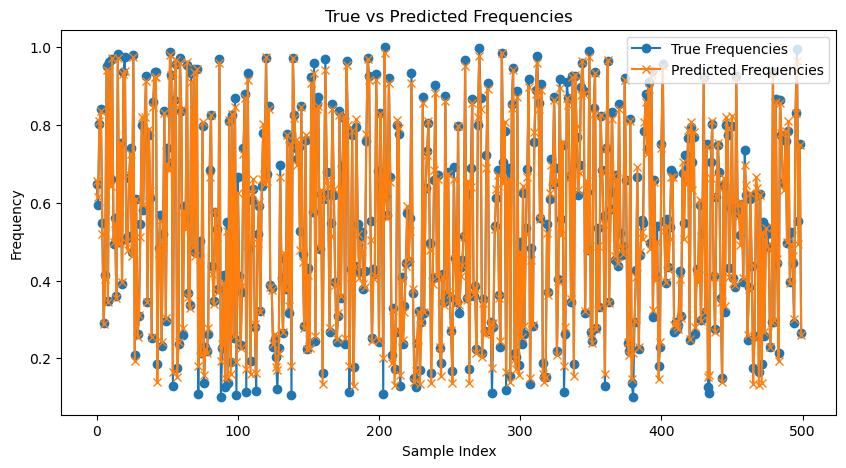

In [ ]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(y_test.numpy(), label="True Frequencies", marker='o')
plt.plot(y_pred_test.numpy(), label="Predicted Frequencies", marker='x')
plt.title("True vs Predicted Frequencies")
plt.xlabel("Sample Index")
plt.ylabel("Frequency")
plt.legend()
plt.show()

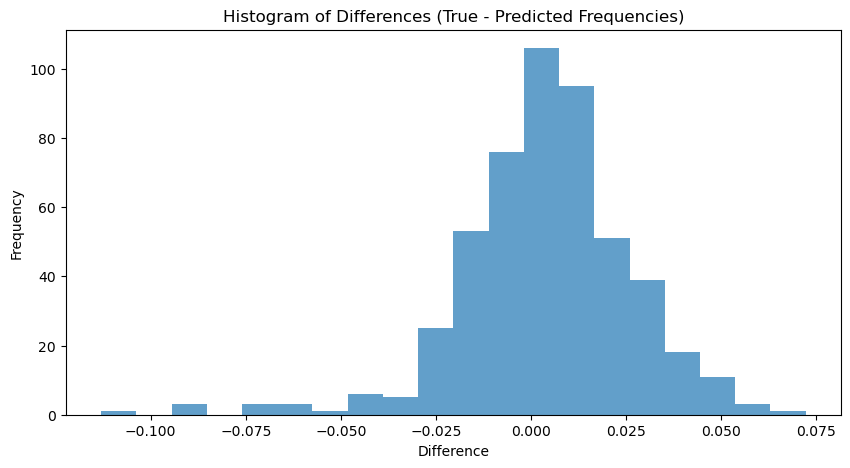

In [ ]:
diffs = y_test - y_pred_test
# histogram of the differences
plt.figure(figsize=(10, 5))
plt.hist(diffs.numpy(), bins=20, alpha=0.7)
plt.title("Histogram of Differences (True - Predicted Frequencies)")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.show() 

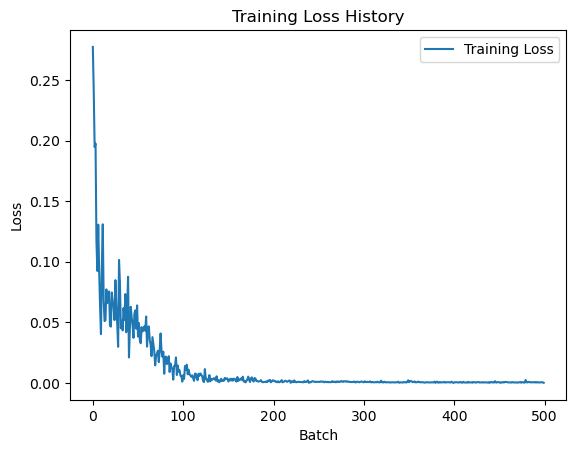

In [ ]:
plt.plot(loss_hist, label="Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()


In [ ]:
params_hist_nice = {
    key: np.array([i[key].detach().numpy() for i in params_hist])
    for key in params_hist[0].keys()
}
print(params_hist_nice.keys())

dict_keys(['positions', 'local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2', 'global_pulse_duration', 'local_pulse_duration', 'embed_pulse_duration', 'conv_params', '0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])


In [ ]:
positions_hist = np.array([i["positions"].detach().numpy() for i in params_hist])
local_pulses_omega_1_hist = np.array([i["local_pulses_omega_1"].detach().numpy() for i in params_hist])
local_pulses_delta_1_hist = np.array([i["local_pulses_delta_1"].detach().numpy() for i in params_hist])

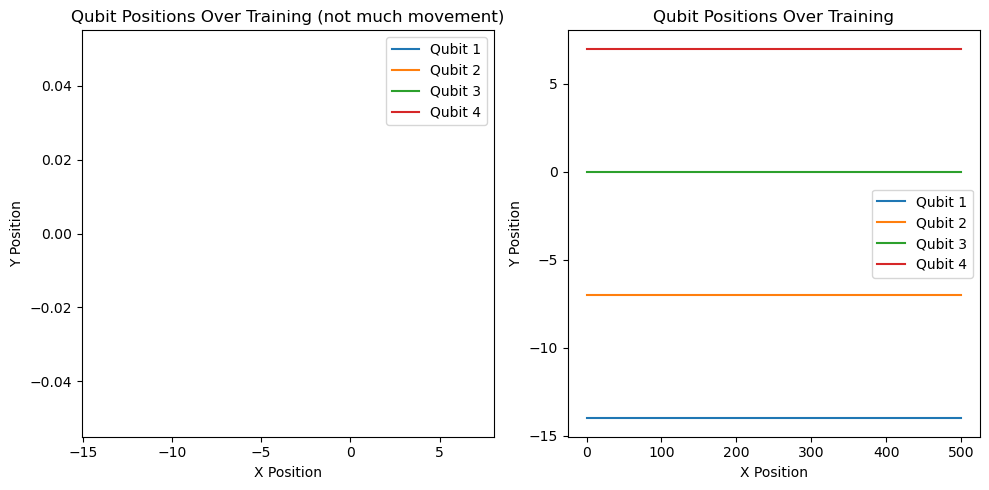

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
for qubit in range(positions_hist.shape[1]):
    plt.plot(positions_hist[:, qubit, 0], positions_hist[:, qubit, 1], label=f"Qubit {qubit+1}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training (not much movement)")
plt.legend()
plt.sca(axs[1])
# only first qubit
plt.plot(positions_hist[:, 0, 0], label="Qubit 1")
plt.plot(positions_hist[:, 1, 0], label="Qubit 2")
plt.plot(positions_hist[:, 2, 0], label="Qubit 3")
plt.plot(positions_hist[:, 3, 0], label="Qubit 4")
# plt.plot(positions_hist[:, 4, 0], label="Qubit 5")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training")
plt.legend()
plt.tight_layout()  
plt.show()  

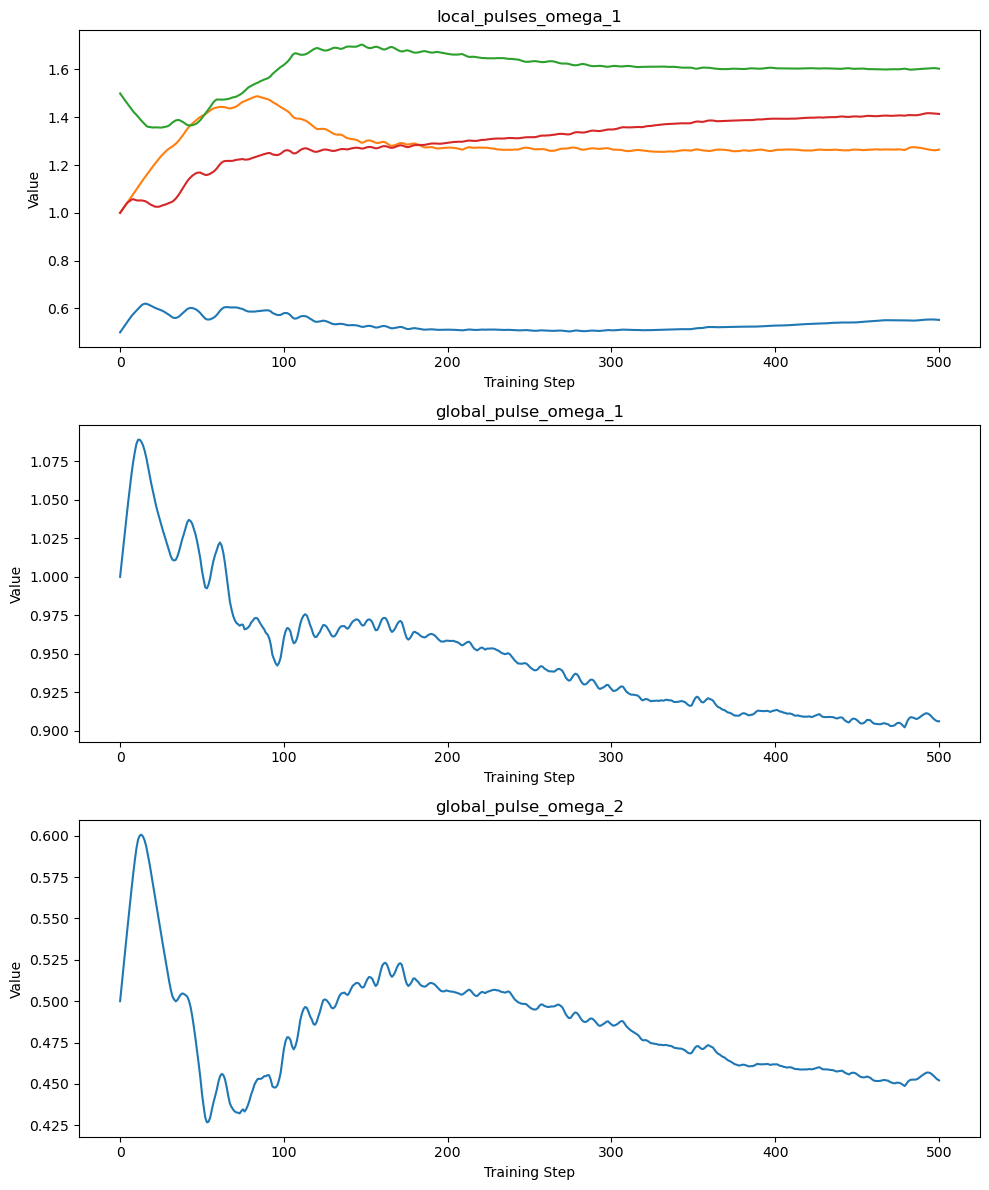

In [ ]:
plot_keys = ['local_pulses_omega_1', 'global_pulse_omega_1', 'global_pulse_omega_2']
fig, axs = plt.subplots(len(plot_keys), 1, figsize=(10, 4 * len(plot_keys)))
for i, key in enumerate(plot_keys):
    axs[i].plot(params_hist_nice[key])
    axs[i].set_title(key)
    axs[i].set_xlabel("Training Step")
    axs[i].set_ylabel("Value")
plt.tight_layout()
plt.show()  

In [ ]:
import pickle

# number of learned parameters, i.e. with require_grad=True
NAHEA_CNN.train()
# number of parameters
n_params = sum(v.numel() for p, v in NAHEA_CNN.parameters().items() if v.requires_grad)
print(f"Number of trainable parameters: {n_params}")
# save training history
os.makedirs("losses_hist", exist_ok=True)
with open("losses_hist/NAHEA_CNN_dist_grad_false_train_hist_2025_07_28.pickle", "wb") as f:
    pickle.dump(
        {
            "loss_hist": loss_hist,
            "loss_hist_val": loss_hist_val,
            "params_hist": params_hist,
            "hparams": hparams,
            loss_test.item(): "test_loss",
            "n_learned_parameters": n_params,
        },
        f,
    )

Number of trainable parameters: 143
